In [4]:
import sys
sys.path.append('../../../FinRecipes/FinRecipes')
from preprocess import Load_n_Preprocess
from feature_extraction import Feature_Engineer
# from FinRecipes import Load_n_Preprocess, Feature_Engineer

TICKERS_LIST_WORLD = ['AAPL']
START_DATE = '2020-01-01'
END_DATE = '2024-12-01'
PATH_DAILY_DATA = "../../Data/df_ohlcv_daily.h5"
LP = Load_n_Preprocess(TICKERS_LIST_WORLD, START_DATE, END_DATE, path_daily_data = PATH_DAILY_DATA)
df = LP.load_daily_data()
print(df)

           date   tic        open        high         low       close  \
0    2020-01-02  AAPL   74.059998   75.150002   73.797501   75.087502   
1    2020-01-03  AAPL   74.287498   75.144997   74.125000   74.357498   
2    2020-01-06  AAPL   73.447502   74.989998   73.187500   74.949997   
3    2020-01-07  AAPL   74.959999   75.224998   74.370003   74.597504   
4    2020-01-08  AAPL   74.290001   76.110001   74.290001   75.797501   
...         ...   ...         ...         ...         ...         ...   
1024 2024-01-29  AAPL  192.009995  192.199997  189.580002  191.729996   
1025 2024-01-30  AAPL  190.940002  191.800003  187.470001  188.039993   
1026 2024-01-31  AAPL  187.039993  187.100006  184.350006  184.399994   
1027 2024-02-01  AAPL  183.990005  186.949997  183.820007  186.860001   
1028 2024-02-02  AAPL  179.860001  187.330002  179.250000  185.850006   

       adj_close     volume  
0      73.152657  135480400  
1      72.441452  146322800  
2      73.018700  118387200  
3  

In [5]:
FE = Feature_Engineer(use_technical_indicator = True,
                tech_indicator_list = ['rsi_14','close_21_sma'],
                path_data = PATH_DAILY_DATA
                )

df_processed, features_list = FE.add_daily_features(df)
df_processed

rsi_14 is added to the dataframe
close_21_sma is added to the dataframe
After feature extraction, ffill and bfill, the number of null value are    0.


,date,tic,open,high,low,close,adj_close,volume,rsi_14,close_21_sma
0,2020-01-02,AAPL,74.059998,75.150002,73.797501,75.087502,73.152657,135480400,0.000000,75.087502
1,2020-01-03,AAPL,74.287498,75.144997,74.125000,74.357498,72.441452,146322800,0.000000,74.722500
2,2020-01-06,AAPL,73.447502,74.989998,73.187500,74.949997,73.018700,118387200,46.640262,74.798332
3,2020-01-07,AAPL,74.959999,75.224998,74.370003,74.597504,72.675270,108872000,35.909731,74.748125
4,2020-01-08,AAPL,74.290001,76.110001,74.290001,75.797501,73.844360,132079200,65.234063,74.958000
...,...,...,...,...,...,...,...,...,...,...
1024,2024-01-29,AAPL,192.009995,192.199997,189.580002,191.729996,191.729996,47145600,53.929650,188.375237
1025,2024-01-30,AAPL,190.940002,191.800003,187.470001,188.039993,188.039993,55859400,45.881797,188.111427
1026,2024-01-31,AAPL,187.039993,187.100006,184.350006,184.399994,184.399994,55467800,39.603456,187.724284
1027,2024-02-01,AAPL,183.990005,186.949997,183.820007,186.860001,186.860001,64885400,45.073674,187.782379


In [6]:
# Check for missing values in the DataFrame
missing_values_count = df_processed.isnull().sum()

# Print the count of missing values
print("Number of missing values:", missing_values_count)

Number of missing values: date            0
tic             0
open            0
high            0
low             0
close           0
adj_close       0
volume          0
rsi_14          0
close_21_sma    0
dtype: int64


In [33]:
# Import necessary libraries
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.statistics import check_seasonality, plot_acf
from darts.metrics import mse

# Assuming 'df' is the dataframe containing OHLCV data of AAPL with RSI14 and SMA21 as features

# Create a TimeSeries object from the dataframe
series = TimeSeries.from_dataframe(df_processed, time_col='date', value_cols=['close', 'rsi_14', 'close_21_sma'], fill_missing_dates=True, freq='B')

In [34]:
# Fill missing values with forward filling
series = series.fill_missing(method='ffill')
# series = series.dropna()

AttributeError: 'TimeSeries' object has no attribute 'fill_missing'

<Axes: xlabel='date'>

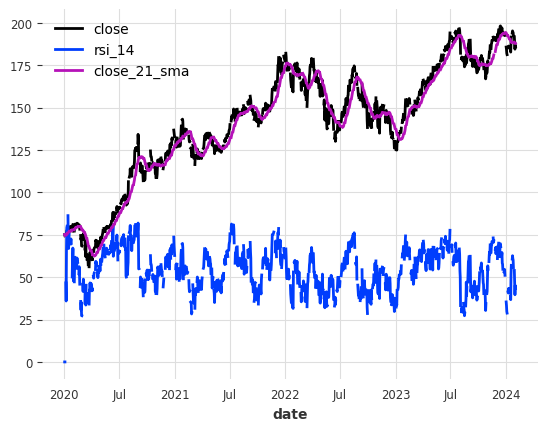

In [30]:
series.plot()

AttributeError: 'TimeSeries' object has no attribute 'dropna'

In [31]:
# Convert TimeSeries to DataFrame
df = series.pd_dataframe()

# Check for missing values in the DataFrame
missing_values_count = df.isnull().sum()

# Print the count of missing values
print("Number of missing values:", missing_values_count)

Number of missing values: component
close           464
rsi_14          464
close_21_sma    464
dtype: int64


In [16]:
len(series)

1067

<Axes: xlabel='date'>

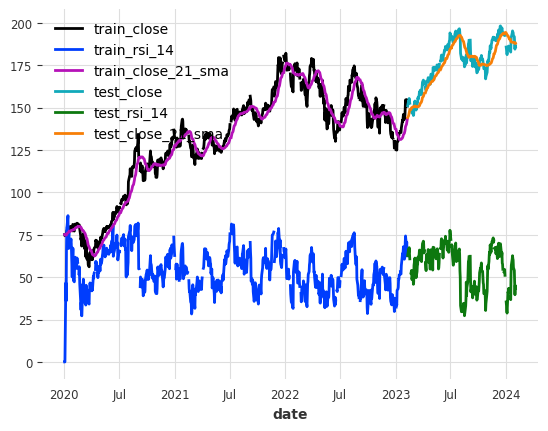

In [17]:
train, test = series[:-256], series[-256:]

train.plot(label='train')
test.plot(label='test')

In [18]:
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler

train_scaler = Scaler()
scaled_train = train_scaler.fit_transform(train)

model = NBEATSModel(
    input_chunk_length=21, 
    output_chunk_length=5,
    generic_architecture=True,
    random_state=42)

model.fit(
    scaled_train,
    epochs=50,
    verbose=True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.5 M 
---------------------------------------------------
6.5 M     Trainable params
1.7 K     Non-trainable params
6.5 M     Total params
26.016    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=21, output_chunk_length=5, random_state=42)

In [8]:
# # Initialize and fit the NBEATS model
# model = NBEATSModel(input_chunk_length=100, output_chunk_length=5, n_epochs=100, random_state=0)
# model.fit(series)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='date'>

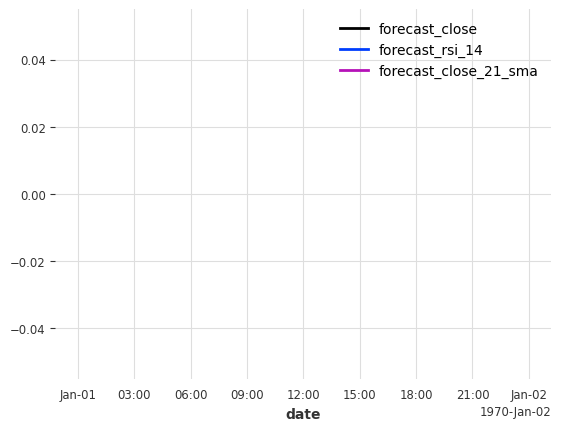

In [23]:
# Forecast 3 and 5 days ahead
pred = model.predict(n=30,series=test)
# pred_5_days = model.predict(n=5)
# test.plot(label='actual')
pred.plot(label='forecast')
# plt.legend();
# print('MAPE = {:.2f}%'.format(mape(series_air_scaled, pred)))

In [24]:
pred

<TimeSeries (DataArray) (date: 30, component: 3, sample: 1)> Size: 720B
array([[[nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan]],

...

       [[nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan]]])
Coordinates:
  * date       (date) datetime64[ns] 240B 2024-02-05 2024-02-06 ... 2024-03-15
  * component  (component) object 24B 'close' 'rsi_14' 'close_21_sma'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [ ]:
# pred = nbeats.predict(n=5, series=train_air)

# series_air_scaled.plot(label='actual')
# pred.plot(label='forecast')
# plt.legend();
# print('MAPE = {:.2f}%'.format(mape(series_air_scaled, pred)))

In [10]:
pred_5_days

<TimeSeries (DataArray) (date: 5, component: 3, sample: 1)> Size: 120B
array([[[nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan]],

       [[nan],
        [nan],
        [nan]]])
Coordinates:
  * date       (date) datetime64[ns] 40B 2024-01-29 2024-01-30 ... 2024-02-02
  * component  (component) object 24B 'close' 'rsi_14' 'close_21_sma'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [ ]:


# Forecast 3 and 5 days ahead
pred_3_days = model.predict(n=3)
pred_5_days = model.predict(n=5)

# Evaluate the predictions in terms of directionality
directionality_3_days = (pred_3_days[-1] - pred_3_days[0]) / pred_3_days[0]
directionality_5_days = (pred_5_days[-1] - pred_5_days[0]) / pred_5_days[0]

print(f"Directionality for 3-day prediction: {directionality_3_days}")
print(f"Directionality for 5-day prediction: {directionality_5_days}")

# Evaluate the predictions in terms of MSE
mse_3_days = mse(series[-3:], pred_3_days)
mse_5_days = mse(series[-5:], pred_5_days)

print(f"MSE for 3-day prediction: {mse_3_days}")
print(f"MSE for 5-day prediction: {mse_5_days}")